In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = "../model/keypoint_classifier/new_keypoint.csv"
model_save_path = '../model/keypoint_classifier/no_pointer.hdf5'
tflite_save_path = '../model/keypoint_classifier/no_pointer.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 7

# Dataset reading & Filtering

In [4]:
import numpy as np
import pandas as pd


# Read the dataset from the CSV file
df = pd.read_csv(dataset)

# Filter rows with label 7
data = df[df[df.columns[0]] != 7]

# Data Balancing

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Specify the target variable
balance_by = data.columns[0]

# Function to determine the sampling strategy
def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

# Calculate the median count for balancing
n_samples = int(data[balance_by].value_counts().median())

# Balancing the data using RandomUnderSampler and RandomOverSampler
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy(data.drop(balance_by, axis=1), data[balance_by], n_samples, t='majority'))
X_under, y_under = under_sampler.fit_resample(data.drop(balance_by, axis=1), data[balance_by])

over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'))
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

balanced_data = pd.DataFrame(X_bal)
balanced_data[balance_by] = y_bal

# Print class distribution before resampling
unique_classes_before, class_counts_before = np.unique(data[balance_by], return_counts=True)
print("Class distribution before resampling:")
for class_label, count in zip(unique_classes_before, class_counts_before):
    print(f"Class {class_label}: {count} instances")

# Print class distribution after resampling
unique_classes_after, class_counts_after = np.unique(balanced_data[balance_by], return_counts=True)
print("\nClass distribution after resampling:")
for class_label, count in zip(unique_classes_after, class_counts_after):
    print(f"Class {class_label}: {count} instances")


Class distribution before resampling:
Class 0: 4223 instances
Class 1: 3929 instances
Class 2: 3871 instances
Class 3: 3283 instances
Class 4: 3242 instances
Class 5: 3256 instances
Class 6: 3223 instances

Class distribution after resampling:
Class 0: 3283 instances
Class 1: 3283 instances
Class 2: 3283 instances
Class 3: 3283 instances
Class 4: 3283 instances
Class 5: 3283 instances
Class 6: 3283 instances


In [6]:
balanced_data.head()

,0.0,0.0.1,0.23605150214592274,-0.3776824034334764,0.30472103004291845,-0.630901287553648,0.3605150214592275,-0.8412017167381974,0.2832618025751073,-0.9957081545064378,...,-0.5150214592274678,-0.2017167381974249,-0.5793991416309013,0.11158798283261803,-0.6738197424892703.1,0.15450643776824036,-0.51931330472103,0.04721030042918455,-0.4592274678111588,0
0,0.0,0.0,0.145763,-0.142373,0.189831,-0.305085,0.176271,-0.440678,0.172881,-0.545763,...,-0.952542,-0.189831,-0.379661,-0.186441,-0.576271,-0.179661,-0.688136,-0.169492,-0.786441,0
1,0.0,0.0,-0.170659,-0.176647,-0.263473,-0.371257,-0.317365,-0.529940,-0.368263,-0.652695,...,-0.943114,0.131737,-0.583832,0.155689,-0.718563,0.155689,-0.781437,0.149701,-0.838323,0
2,0.0,0.0,0.161798,-0.121348,0.226966,-0.294382,0.244944,-0.462921,0.301124,-0.582022,...,-0.925843,-0.191011,-0.404494,-0.202247,-0.559551,-0.204494,-0.662921,-0.200000,-0.761798,0
3,0.0,0.0,-0.109434,-0.154717,-0.150943,-0.350943,-0.109434,-0.509434,-0.052830,-0.626415,...,-0.950943,0.128302,-0.332075,0.173585,-0.566038,0.200000,-0.701887,0.215094,-0.803774,0
4,0.0,0.0,0.191489,-0.099291,0.269504,-0.269504,0.269504,-0.443262,0.290780,-0.563830,...,-0.985816,-0.166667,-0.397163,-0.145390,-0.620567,-0.127660,-0.744681,-0.102837,-0.847518,0


In [7]:
X_dataset = np.array(balanced_data.drop(balance_by, axis=1))
X_dataset

array([[ 0.        ,  0.        ,  0.14576271, ..., -0.68813559,
        -0.16949153, -0.78644068],
       [ 0.        ,  0.        , -0.17065868, ..., -0.78143713,
         0.1497006 , -0.83832335],
       [ 0.        ,  0.        ,  0.16179775, ..., -0.66292135,
        -0.2       , -0.76179775],
       ...,
       [ 0.        ,  0.        ,  0.32786885, ...,  0.40983607,
        -0.2704918 ,  0.43442623],
       [ 0.        ,  0.        ,  0.30735931, ...,  0.51515152,
        -0.03030303,  0.43290043],
       [ 0.        ,  0.        ,  0.30508475, ...,  0.50847458,
        -0.20338983,  0.48305085]])

In [8]:
y_dataset = np.array(balanced_data[balance_by])
y_dataset

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [13]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1147 (4.48 KB)
Trainable params: 1147 (4.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [30]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback]
)

Epoch 1/1000
115/135 [========================>.....] - ETA: 0s - loss: 0.5257 - accuracy: 0.8378
Epoch 1: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 1s 3ms/step - loss: 0.5213 - accuracy: 0.8375 - val_loss: 0.6262 - val_accuracy: 0.7503
Epoch 2/1000
 74/135 [===============>..............] - ETA: 0s - loss: 0.5100 - accuracy: 0.8339

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/135 [==========================>...] - ETA: 0s - loss: 0.5119 - accuracy: 0.8354
Epoch 2: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.5096 - accuracy: 0.8363 - val_loss: 0.6323 - val_accuracy: 0.7477
Epoch 3/1000
128/135 [===========================>..] - ETA: 0s - loss: 0.5186 - accuracy: 0.8342
Epoch 3: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.5208 - accuracy: 0.8331 - val_loss: 0.6098 - val_accuracy: 0.7508
Epoch 4/1000
126/135 [===========================>..] - ETA: 0s - loss: 0.5117 - accuracy: 0.8353
Epoch 4: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.5109 - accuracy: 0.8350 - val_loss: 0.6380 - val_accuracy: 0.7424
Epoch 5/1000
128/135 [===========================>..] - ETA: 0s - loss: 0.5190 - accuracy: 0.8361
Epoch 5: saving mo

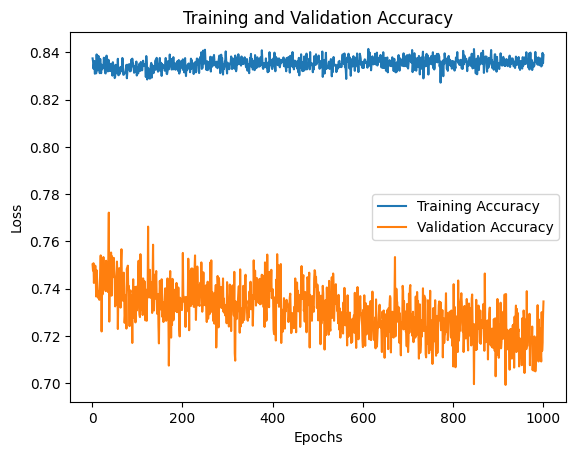

In [34]:
import matplotlib.pyplot as plt
training_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Accuracy')
plt.plot(epochs, validation_loss, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
131/135 [============================>.] - ETA: 0s - loss: 1.0147 - accuracy: 0.6496
Epoch 1: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 1s 4ms/step - loss: 1.0060 - accuracy: 0.6529 - val_loss: 0.5563 - val_accuracy: 0.8789
Epoch 2/1000
125/135 [==========================>...] - ETA: 0s - loss: 0.6893 - accuracy: 0.7721
Epoch 2: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.7739 - val_loss: 0.4462 - val_accuracy: 0.8877
Epoch 3/1000
130/135 [===========================>..] - ETA: 0s - loss: 0.6156 - accuracy: 0.8042
Epoch 3: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.8044 - val_loss: 0.3790 - val_accuracy: 0.9100
Epoch 4/1000
134/135 [============================>.] - ETA: 0s - loss: 0.5672 - accuracy: 0.8196
Epoch

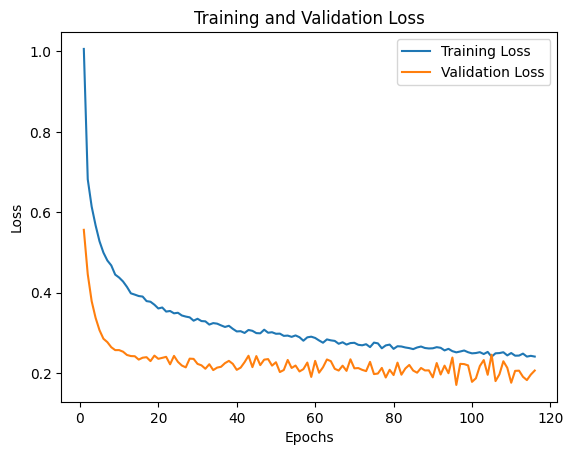

In [37]:
import matplotlib.pyplot as plt
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

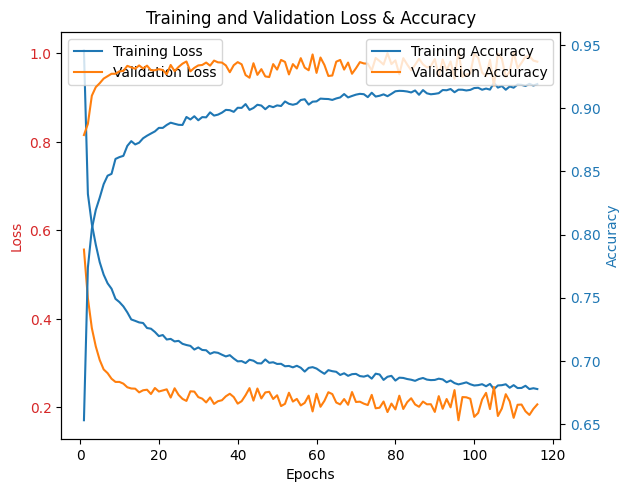

In [42]:
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

# Plotting the training and validation loss on the same chart
epochs = range(1, len(training_loss) + 1)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, training_loss, label='Training Loss')
ax1.plot(epochs, validation_loss, label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(epochs, training_accuracy, label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Training and Validation Loss & Accuracy')
plt.show()

In [43]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
117/135 [=========================>....] - ETA: 0s - loss: 0.9662 - accuracy: 0.7043
Epoch 1: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 1s 4ms/step - loss: 0.9129 - accuracy: 0.7197 - val_loss: 0.4810 - val_accuracy: 0.8629
Epoch 2/1000
 72/135 [===============>..............] - ETA: 0s - loss: 0.5190 - accuracy: 0.8449

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/135 [===========================>..] - ETA: 0s - loss: 0.4926 - accuracy: 0.8557
Epoch 2: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.4918 - accuracy: 0.8565 - val_loss: 0.3469 - val_accuracy: 0.9123
Epoch 3/1000
127/135 [===========================>..] - ETA: 0s - loss: 0.3896 - accuracy: 0.8911
Epoch 3: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.3887 - accuracy: 0.8919 - val_loss: 0.2799 - val_accuracy: 0.9175
Epoch 4/1000
124/135 [==========================>...] - ETA: 0s - loss: 0.3297 - accuracy: 0.9061
Epoch 4: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.3304 - accuracy: 0.9054 - val_loss: 0.2377 - val_accuracy: 0.9290
Epoch 5/1000
114/135 [========================>.....] - ETA: 0s - loss: 0.3021 - accuracy: 0.9108
Epoch 5: saving mo

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


130/135 [===========================>..] - ETA: 0s - loss: 0.9383 - accuracy: 0.7091
Epoch 1: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 2s 5ms/step - loss: 0.9274 - accuracy: 0.7131 - val_loss: 0.4777 - val_accuracy: 0.8395
Epoch 2/1000
 65/135 [=============>................] - ETA: 0s - loss: 0.5162 - accuracy: 0.8484

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/135 [===========================>..] - ETA: 0s - loss: 0.4875 - accuracy: 0.8597
Epoch 2: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.4864 - accuracy: 0.8602 - val_loss: 0.3581 - val_accuracy: 0.9111
Epoch 3/1000
119/135 [=========================>....] - ETA: 0s - loss: 0.3870 - accuracy: 0.8907
Epoch 3: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.3847 - accuracy: 0.8915 - val_loss: 0.2850 - val_accuracy: 0.9172
Epoch 4/1000
122/135 [==========================>...] - ETA: 0s - loss: 0.3256 - accuracy: 0.9059
Epoch 4: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.3241 - accuracy: 0.9061 - val_loss: 0.2470 - val_accuracy: 0.9233
Epoch 5/1000
127/135 [===========================>..] - ETA: 0s - loss: 0.2951 - accuracy: 0.9124
Epoch 5: saving mo

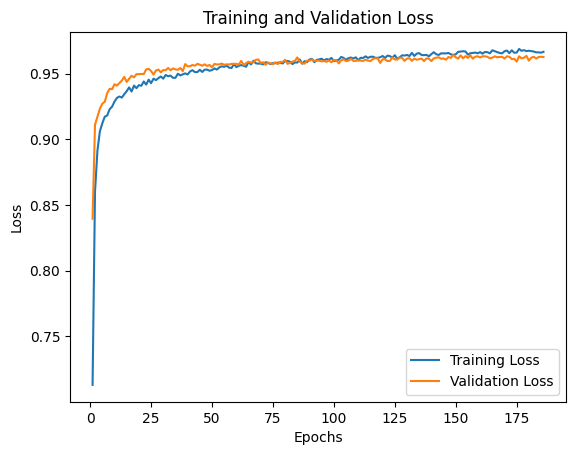

In [15]:
import matplotlib.pyplot as plt
training_loss = history3.history['accuracy']
validation_loss = history3.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

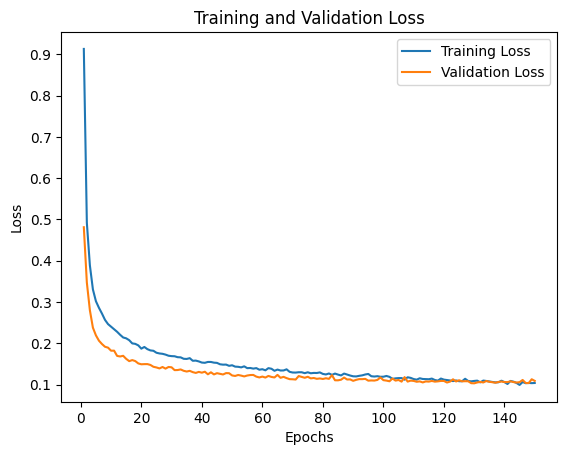

In [44]:
import matplotlib.pyplot as plt
training_loss = history3.history['loss']
validation_loss = history3.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

45/45 [==============================] - 0s 1ms/step - loss: 0.6614 - accuracy: 0.7374


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 95ms/step
[6.2351692e-03 6.3745510e-08 2.7964256e-10 3.9568387e-02 9.5401740e-01
 5.0721090e-05 1.2826838e-04]
4


# Confusion matrix

In [18]:
series = pd.Series(y_test)

# Use the value_counts method
value_counts_result = series.value_counts()

print(value_counts_result)


1    864
5    834
4    820
3    818
2    810
6    804
0    796
Name: count, dtype: int64


180/180 [==============================] - 0s 1ms/step
[0, 1, 2, 3, 4, 5, 6]


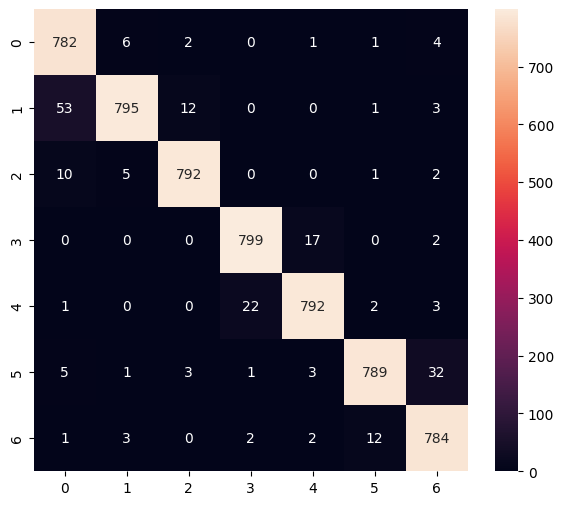

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       796
           1       0.98      0.92      0.95       864
           2       0.98      0.98      0.98       810
           3       0.97      0.98      0.97       818
           4       0.97      0.97      0.97       820
           5       0.98      0.95      0.96       834
           6       0.94      0.98      0.96       804

    accuracy                           0.96      5746
   macro avg       0.96      0.96      0.96      5746
weighted avg       0.96      0.96      0.96      5746



In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    print(labels)
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [46]:
import numpy as np
from sklearn.metrics import f1_score

# Assuming your model is already trained and you have the test set (X_test, y_test)

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Weighted F1 Score: {f1}')

180/180 [==============================] - 0s 1ms/step
Weighted F1 Score: 0.9629411361362127


# Convert to model for Tensorflow-Lite

In [20]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmpv1j46gep\assets


INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmpv1j46gep\assets


6676

# Inference test

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [23]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
input_data = np.array([X_test[0]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [25]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 2 ms


In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.2351665e-03 6.3745510e-08 2.7964359e-10 3.9568387e-02 9.5401740e-01
 5.0721133e-05 1.2826851e-04]
4


In [27]:
y_test[0]

4